In [1]:
import gym
import matplotlib
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

from tqdm import tqdm

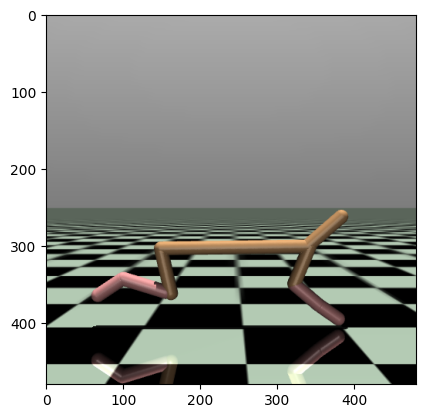

In [ ]:
# env = gym.make('HalfCheetah-v2', render_mode="rgb_array")
# env.reset()

# img = plt.imshow(env.render()) # only call this once

# for _ in range(10):
#     img.set_data(env.render()) # just update the data
#     display.display(plt.gcf())
#     display.clear_output(wait=True)
#     action = env.action_space.sample()
#     env.step(action)
    
# env.close()

In [15]:
## model

class TimeEmbedding(nn.Module):
    """form the time-embedding"""
    def __init__(self, tdim=10):
        super(TimeEmbedding, self).__init__()
        self.freqs = (2 * np.pi) / torch.arange(2, tdim + 1, 2).unsqueeze(0)

    def forward(self, t):
        sin_emb = torch.from_numpy(np.sin(self.freqs * t)).to(t.device)
        cos_emb = torch.from_numpy(np.cos(self.freqs * t)).to(t.device)
        return torch.cat([sin_emb, cos_emb], dim=-1)
    
class MLP(nn.Module):
    """a simple MLP architecture for implementing both vanilla-MLP and
    prospective-MLP
    """
    def __init__(self, in_dim=1, out_dim=2, arch=[1, 8, 8, 2], tdim=50, prospective=False):
        super(MLP, self).__init__()
        self.prospective = prospective

        self.layers = nn.ModuleList()
        for i in range(len(arch)-1):
            if prospective and i == 0:
                self.layers.append(nn.Linear(arch[i] + tdim, arch[i+1]))
            else:
                self.layers.append(nn.Linear(arch[i], arch[i+1]))

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()


    def forward(self, x, t):
        if self.prospective:
            x = torch.cat([x, t.unsqueeze(-1)], dim=-1)
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i < len(self.layers)-1:
                x = self.relu(x)
        return self.tanh(x)

In [ ]:
## Trainer class

import random

def set_seed(acorn):
    """set random seed"""
    random.seed(acorn)
    np.random.seed(acorn)
    torch.manual_seed(acorn)
    torch.cuda.manual_seed(acorn)
    torch.cuda.manual_seed_all(acorn)

def get_dataloader(data_buffer, bs=16):
    """obtain the dataloader"""
    t = torch.Tensor(data_buffer['t']).float()
    s = torch.from_numpy(np.stack(data_buffer['s'])).float()
    a = torch.from_numpy(np.stack(data_buffer['a'])).float()
    r = torch.Tensor(data_buffer['r']).float()

    dataset = TensorDataset(t, s, a, r)

    trainloader = DataLoader(
        dataset,
        batch_size=bs,
        shuffle=True,
        drop_last=True
    )
    return trainloader

class Trainer:
    """trainer class for the models"""
    def __init__(self, model, train_loader, criterion, optimizer, device, verbose=False):
        self.model = model
        self.train_loader = train_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.verbose = verbose

    def train_one_epoch(self):
        self.model.train()
        total_loss = 0.0
        
        for batch in self.train_loader:
            batch = [b.to(self.device) for b in batch]
            t, s, a, r = batch
            outputs = self.model(s, t)

            loss = self.criterion(outputs.squeeze(), a)

            self.optimizer.zero_grad()  
            loss.backward()            
            self.optimizer.step() 

            total_loss += loss.clone().detach().item()

        return total_loss / len(self.train_loader)

    def train(self, num_epochs):
        if self.verbose:
            progress_bar = tqdm(range(num_epochs), desc="Training", unit="epoch")
        else:
            progress_bar = range(num_epochs)

        for epoch in progress_bar:
            train_loss = self.train_one_epoch()
            if self.verbose:
                progress_bar.set_description(f"Epoch [{epoch + 1}/{num_epochs}] - Loss: {train_loss:.4f}")

In [30]:
T = 10000 # total number of steps
k = 500 # data collection duration
batch_size = 16
epsilon = 0.8

In [ ]:
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MLP(prospective=False, arch=[17, 32, 32, 6])
model.to(device)

optimizer = torch.optim.SGD(
    model.parameters(), 
    lr=0.01,
    momentum=0.9, 
    nesterov=True,
    weight_decay=0.00001
)
criterion = nn.MSELoss()

env = gym.make('HalfCheetah-v4')
state, _ = env.reset()

train = False
current_policy = model
data_buffer = {
    "t": [],
    "s": [],
    "a": [],
    "r": []
}
for t in range(T):
    if t > 0 and t % k == 0:
        train = True
    else:
        train = False

    # ---------------------------------------------
    # collect data
    # ---------------------------------------------
    if not train:
        print(f"\rData Collecting : {t}", end="", flush=True)

        if np.random.binomial(1, epsilon):
            # explore
            action = env.action_space.sample()
        else:
            # exploit -- get an action from the current policy
            torch_state = torch.from_numpy(state).float().to(device)
            torch_action = current_policy(torch_state, None)

        action = torch_action.detach().cpu().numpy()

        # get next state and reward
        next_state, reward, _, _, _ = env.step(action)

        # store the (state, action, reward) tuple
        for key, val in zip(data_buffer.keys(), (t, state, action, reward)):
            data_buffer[key].append(val)

        state = next_state

    # ---------------------------------------------
    # train model
    # ---------------------------------------------
    else:
        print("\nTraining...")
        train_loader = get_dataloader(data_buffer, bs=batch_size)
        trainer = Trainer(current_policy, train_loader, criterion, optimizer, device, verbose=True)
        trainer.train(num_epochs=100)
        current_policy = trainer.model

        data_buffer = {
            "t": [],
            "s": [],
            "a": [],
            "r": []
        }

    # ---------------------------------------------
    # evaluate model
    # ---------------------------------------------

    

Data Collecting : 0

Data Collecting : 211

/cis/home/adesilva/miniconda3/envs/prol/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Data Collecting : 499
Training...


Epoch [100/100] - Loss: 0.0011: 100%|██████████| 100/100 [00:08<00:00, 11.57epoch/s]

Data Collecting : 508

Data Collecting : 999
Training...


Epoch [100/100] - Loss: 0.0000: 100%|██████████| 100/100 [00:09<00:00, 10.37epoch/s]

Data Collecting : 1002

Data Collecting : 1499
Training...


Epoch [100/100] - Loss: 0.0000: 100%|██████████| 100/100 [00:09<00:00, 10.33epoch/s]

Data Collecting : 1501

Data Collecting : 1999
Training...


Epoch [100/100] - Loss: 0.0000: 100%|██████████| 100/100 [00:09<00:00, 10.44epoch/s]

Data Collecting : 2004

Data Collecting : 2499
Training...


Epoch [20/100] - Loss: 0.0000:  20%|██        | 20/100 [00:02<00:08,  9.99epoch/s]


KeyboardInterrupt: 

In [25]:
np.random.binomial(1, 0.3)

0

In [ ]:
np.random.uniform(0, 1)

In [ ]:
current_policy(torch_state, None)

tensor([-0.0076,  0.0056, -0.0892,  0.1119, -0.0768,  0.1224], device='cuda:0',
       grad_fn=<TanhBackward0>)